# ICaL GA Fitting
Genetic Algorithm Based Fitting for L-Type Calcium Current <br>

In [1]:
import multiprocessing as mp
print(mp.cpu_count())

24


GA Trial 4
*************************************************************************************
Progress: --------------> 80.0 %
generation:  0
Runtime:  0.052654434088617565 mins
Best fitness:  66.39093308934343
generational solution:  [ 0.12376343 12.02807409  6.39966357 34.49586279  5.66673762  0.10836022]


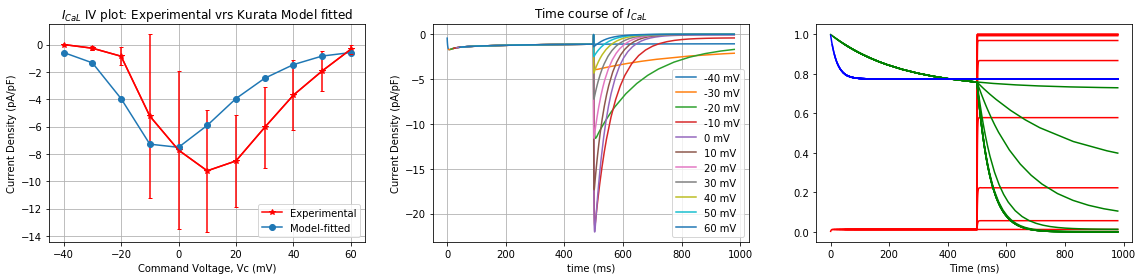

generation:  10
Runtime:  0.6667949460757275 mins
Best fitness:  34.3433847060902
generational solution:  [ 0.12256212  8.67758067  4.66947743 27.20556829  3.73637442  0.14273148]


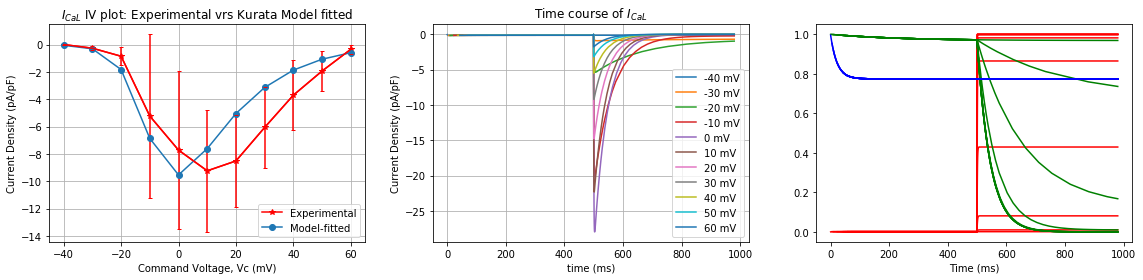

generation:  20
Runtime:  1.2975899606011807 mins
Best fitness:  25.23620163620996
generational solution:  [ 0.13996301  6.98564524  4.74274253 26.16257943  4.24035359  0.13466901]


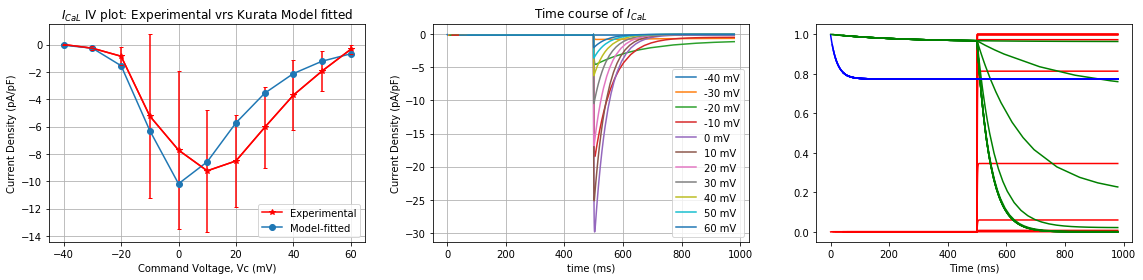

generation:  30
Runtime:  2.0455342191271484 mins
Best fitness:  18.572501016128765
generational solution:  [ 0.15169438  5.26821092  5.39310134 27.22041524  4.02108051  0.12725938]


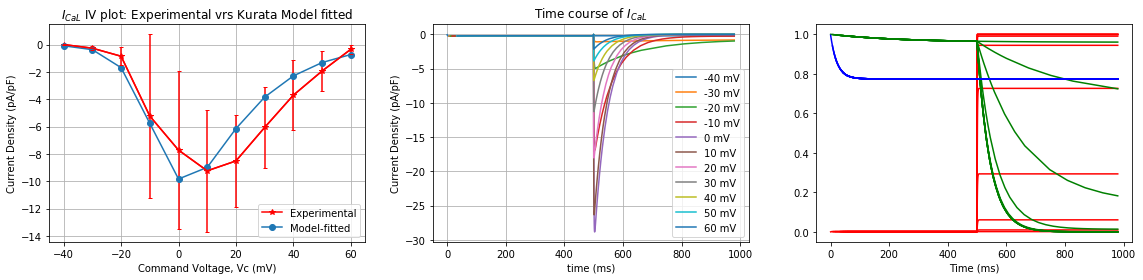

generation:  40
Runtime:  2.7897278174757956 mins
Best fitness:  14.28061199723375
generational solution:  [ 0.16152128  3.92966451  5.45199033 28.2869014   3.94237097  0.14609217]


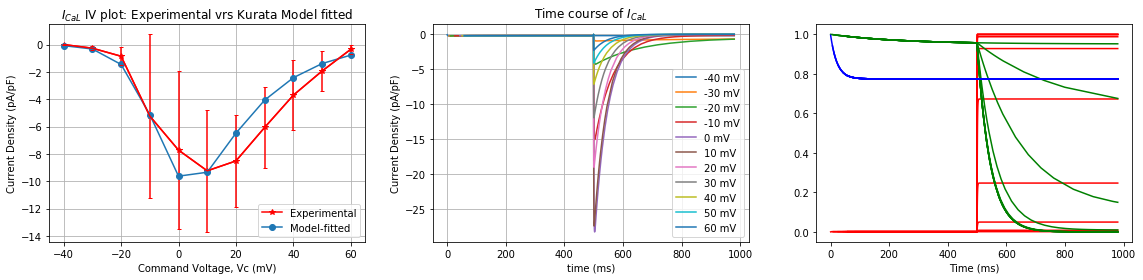

generation:  50
Runtime:  3.629717043073227 mins
Best fitness:  11.503123929477805
generational solution:  [ 0.1731439   2.96924081  5.94635985 27.96127363  4.26265976  0.15857492]


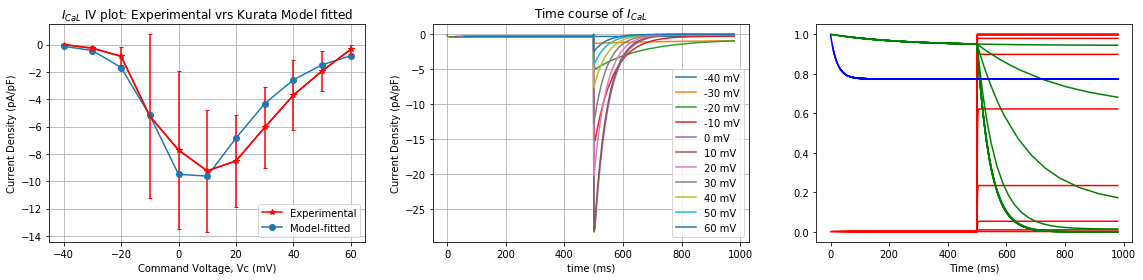

generation:  60
Runtime:  4.51350096995011 mins
Best fitness:  10.068974723459988
generational solution:  [ 0.1774626   2.37299475  6.0438691  28.46173581  4.08952167  0.15087647]


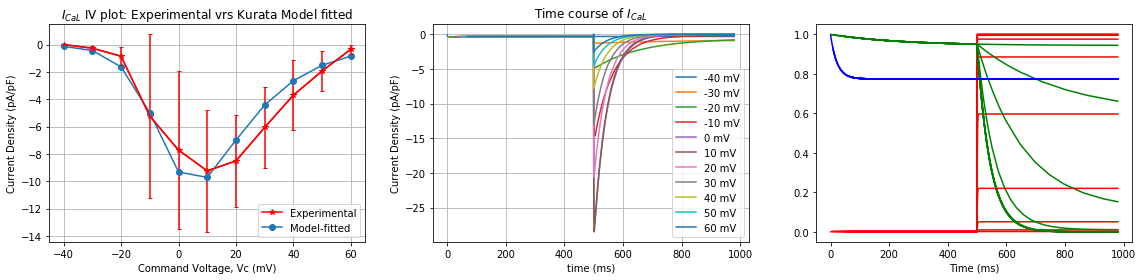

generation:  70
Runtime:  5.563879711460322 mins
Best fitness:  9.20177630443964
generational solution:  [ 0.17997722  1.96666029  6.11217042 28.73649893  3.96898408  0.15253329]


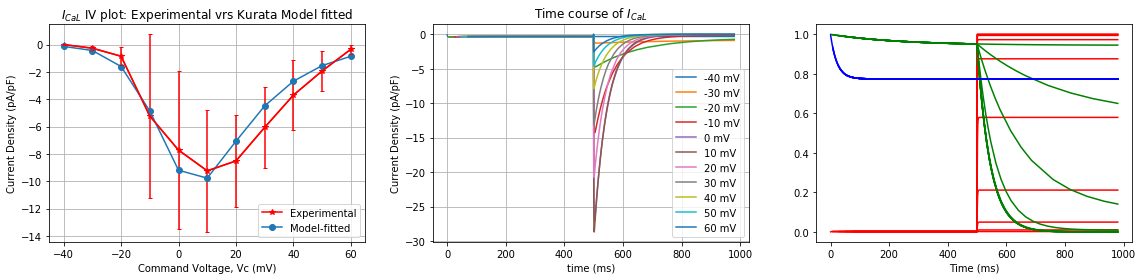

generation:  80
Runtime:  6.703173984618236 mins
Best fitness:  8.619942815127091
generational solution:  [ 0.18097606  1.68385811  6.28594161 26.90359848  4.10355882  0.17229439]


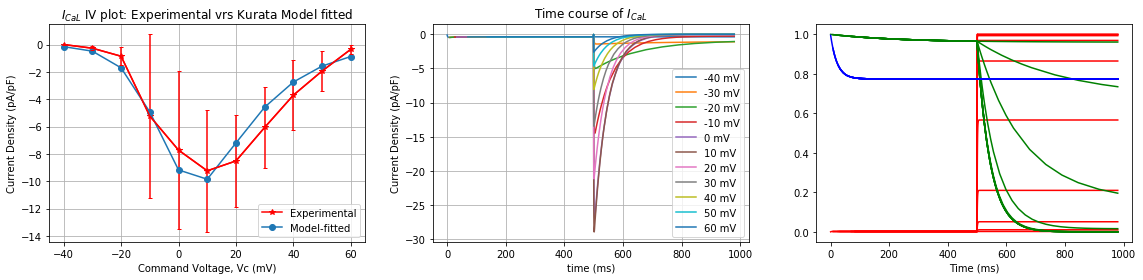

generation:  90
Runtime:  8.014525665032368 mins
Best fitness:  8.365365729917919
generational solution:  [ 0.18011265  1.55809845  6.21773664 26.36060907  4.25562803  0.17143987]


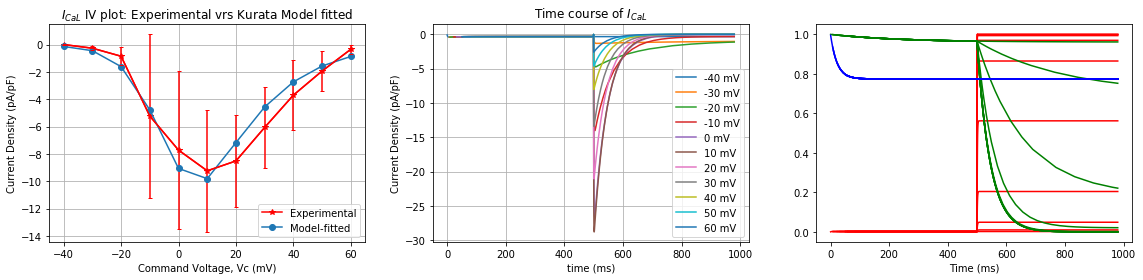

generation:  100
Runtime:  9.59356133295223 mins
Best fitness:  7.865378407985741
generational solution:  [ 0.18547084  1.24555728  6.39535892 25.58408138  4.29488507  0.17704086]


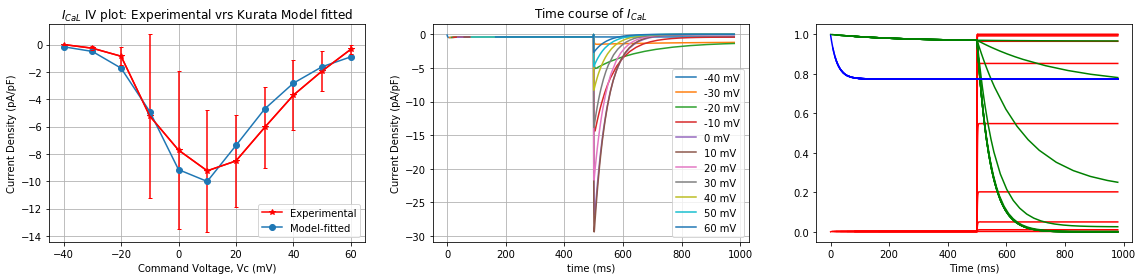

-------------------------------------------------------------------
Best Solution:  [ 0.18547084  1.24555728  6.39535892 25.58408138  4.29488507  0.17704086]
Final Fitness:  7.865378407985741


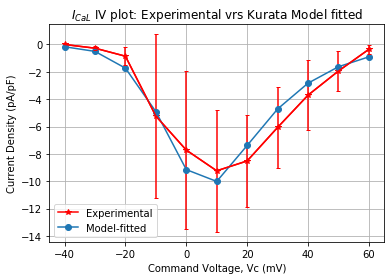

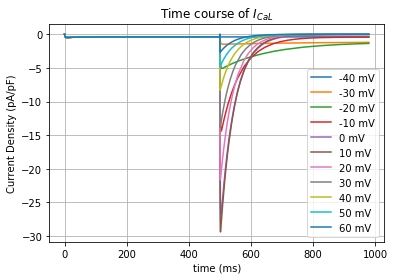

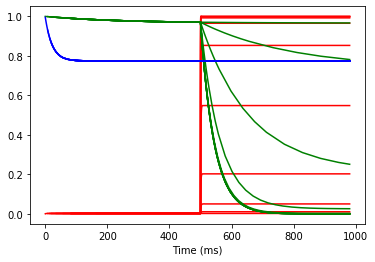

Total Runtime:  9.675080717261881 mins
ini_r2 0.35830831442876754
fit_r2 0.9370250102101868


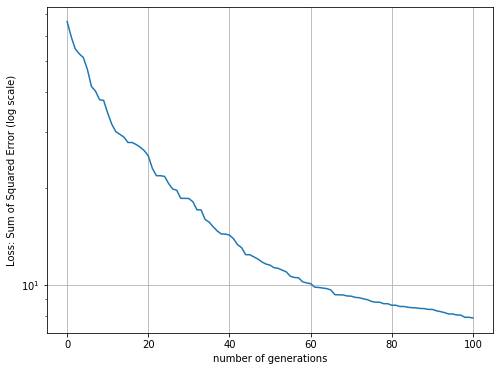

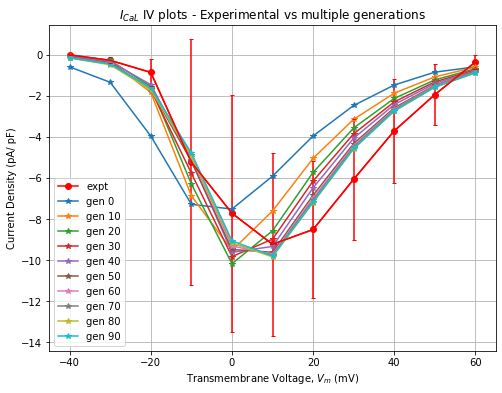

In [2]:
import timeit
import numpy as np
import matplotlib.pyplot as plt
import ICaL_worker
from multiprocessing import Pool
from sklearn.metrics import r2_score
import warnings
import pickle
warnings.filterwarnings('ignore')

class GA_trial:
    gen_num = 0
    loss = 0
    R_sq_ini = 0
    R_sq_fin = 0
    Parameters = 0
    final_fit_Val = 0
    time = 0
    cur_time_fit = 0
    cur_time_ini = 0
    Vcm = 0
    I_peaks_fin = 0
    I_peaks_ini = 0

#initial model
ini_par = np.array([0.2*0.58, 14.1, 6, 30, 5, 0.1]) #reduced ini_par[0] to accelerate convergence
ICaL_IVini = ICaL_worker.ICaL_func(ini_par)
time_ini, plt_ICaL_ini, size = ICaL_worker.ICaL_func_time(ini_par)

Vcm = np.arange(-40, 61, 10) #voltage clamp: command voltages

pop_size = 55 #population size

ICaL_act = np.array(
    [0, -0.268792241, -0.856145789, -5.232952504, -7.721339694, -9.236046139, -8.514716429, -6.064719567, -3.704884839,
 -1.937985962, -0.349954573])
ICaL_err = np.array([0, 0.150744503, 0.669532119, 5.982703588, 5.780490069, 4.469592414, 3.35790912, 2.949954933,
                2.550140897, 1.475404797, 0.348955267])

# fitness
def pop_fitness(ppln):
        p = Pool(processes = 24)
        gen_start_time_parlel = timeit.default_timer()
        ICaL_cur = p.map(ICaL_worker.ICaL_func, ppln)
        gen_finish_time_parlel = timeit.default_timer()
        #print('generation runtime (parallel) = ',(gen_finish_time_parlel - gen_start_time_parlel)/60, 'mins')    
        SSE = np.sum(np.power((ICaL_cur - ICaL_act), 2, dtype=np.float64), axis=1)
        return SSE

#Selecting best parameters
def select_mating_pool(popn, fitness, num_parents):
    parents = np.empty((num_parents, popn.shape[1]))
    for parent_no in range(num_parents):
        max_fit_idx = np.where(fitness == np.min(fitness))  # find max and return its index
        max_fit_idx = max_fit_idx[0][0]  # Select the first index if repetitive
        parents[parent_no, :] = popn[max_fit_idx, :]
        fitness[max_fit_idx] = +9999999999 #add term to ensure parents selection index are not repeated
    return parents

# 2-point crossover
def crossover(parents,
              offspring_size):  # in the case offspring size = (k, 3) where k is the number of desired offsprings
    offspring = np.empty(offspring_size)
    crossover_point1 = np.uint8(np.random.randint(1, offspring_size[1]/2))
    crossover_point2 = np.uint8(np.random.randint(offspring_size[1]/2, offspring_size[1]))

    for n in range(parents.shape[0]):
        # parent selection
        parent1_idx = n % parents.shape[0]  # using modulus helps implement a ring parent selection fashion
        parent2_idx = (n + 1) % parents.shape[0]
        # offspring will have a up to the crossover point proportion from parent1 and parent2 respectively
        # Actual crossover
        # todo: generate two offsprings instead of one
        offspring[n, 0:crossover_point1] = parents[parent1_idx, 0:crossover_point1]
        offspring[n, crossover_point1:crossover_point2] = parents[parent2_idx, crossover_point1:crossover_point2]
        offspring[n, crossover_point2:] = parents[parent1_idx, crossover_point2:]
        #second offspring
        offspring[n + parents.shape[0], 0:crossover_point1] = parents[parent1_idx, 0:crossover_point1]
        offspring[n + parents.shape[0], crossover_point1:]  = parents[parent2_idx, crossover_point1:]
        
    return offspring

#offspring mutation
def mutation(offspring_crossover):
    gen_alpha = np.random.uniform(0.0, 0.1)
#     print(gen_alpha)
    mutation_coeff = np.random.uniform(1-gen_alpha, 1+gen_alpha, (offspring_crossover.shape[0], offspring_crossover.shape[1]))
    mutants = mutation_coeff*offspring_crossover # various percentage of the parameters
    return mutants

num_of_trials = 5 #for multitrails: Beware the memory may accumulate and prolong compute, so run a trial and restart instead

for trial_count in np.arange(4, num_of_trials): #Used 4 here to do signal trial only as memory was accumulating
    timer_start = timeit.default_timer()
    C = np.empty((pop_size, len(ini_par)))
    pop_alpha = np.random.uniform(0.0, 0.5, C.shape[1])
    # pop_alpha = np.ones(C.shape[1])*0.1
    for i in range(C.shape[1]):
        C[:, i] = np.random.uniform((1 - pop_alpha[i])*ini_par[i], (1 + pop_alpha[i])*ini_par[i], C.shape[0])

    ICaL_cur = np.empty((C.shape[0], len(Vcm)))
    population = C  # initial Population

    print('GA Trial %s' %trial_count)
    print('*************************************************************************************')
    progress = trial_count/(num_of_trials)*100
    print('Progress: --------------> %s'%progress, '%')
    i_plt = 0
    gen_mod = 10
    num_of_gens = 101
    no_plts = num_of_gens/gen_mod
    no_plts = np.int16(no_plts)
    gen_curr_arr = np.zeros((11, num_of_gens))
    num_mating_parents = int(C.shape[0]/5)
    best_gen_fitness = []
    for generation in range(num_of_gens):
        fitness = pop_fitness(population)  # calculate fitness (SSE)
        fitness = np.where(np.isnan(fitness), 1e120, fitness) #handles the dreaded nan's
        best_gn_fit_idx = np.where(fitness == np.min(fitness))
        indx = best_gn_fit_idx[0][0]
        best_gen_fitness.append(fitness[indx])

        if generation%gen_mod == 0:
            best_gn_fit_idx = np.where(fitness == np.min(fitness))
            indx = best_gn_fit_idx[0][0]
            gen_num = np.arange(len(best_gen_fitness))
            timer_stop = timeit.default_timer()
            print('generation: ', generation)
            print('Runtime: ', (timer_stop - timer_start)/60.0, 'mins')
            print('Best fitness: ', fitness[indx])

            y_fit = ICaL_worker.ICaL_func(population[indx])
            t, s, d, f, fca, Cai, Casub, Caup, Carel, jCa_diff, jrel, jup, jtr, plot_ICaL_fit = ICaL_worker.dffca(population[indx])
            start_idx = np.uint16(s/2)
            gen_curr_arr[:, i_plt] = y_fit
            print('generational solution: ',population[indx])
            plt.figure(figsize=(16,4))
            plt.subplot(131)
            plt.plot(Vcm, ICaL_act, 'r-*', Vcm, y_fit, '-o')
            plt.legend(['Experimental', 'Model-fitted'], loc='best')
            plt.errorbar(Vcm, ICaL_act, yerr=ICaL_err, capsize=2, color='red')
            plt.xlabel('Command Voltage, Vc (mV)')
            plt.ylabel('Current Density (pA/pF)')
            plt.title('$I_{CaL}$ IV plot: Experimental vrs Kurata Model fitted')
            plt.grid()

            plt.subplot(132)
            plt.grid()
            plt_cnt = -40
            for j in np.arange(len(Vcm)):     
                plt.plot(t[j, start_idx[j]: s[j]], plot_ICaL_fit[j, start_idx[j]: s[j]], label='%s mV' %plt_cnt)
                plt_cnt = plt_cnt+10
            plt.xlabel('time (ms)')
            plt.ylabel('Current Density (pA/pF)')
            plt.legend(loc='lower right')
            plt.title('Time course of $I_{CaL}$')

            plt.subplot(133)
            for j in np.arange(len(Vcm)):
                plt.plot(t[j, start_idx[j]: s[j]], d[j, start_idx[j]: s[j]], '-r')
            for j in np.arange(len(Vcm)):
                plt.plot(t[j, start_idx[j]: s[j]], f[j, start_idx[j]: s[j]], '-g')
            for j in np.arange(len(Vcm)):
                plt.plot(t[j, start_idx[j]: s[j]], fca[j, start_idx[j]: s[j]], '-b')

            plt.xlabel('Time (ms)')
            plt.tight_layout()
            plt.show()

        if generation == num_of_gens-1:
            Best_Sol = population[indx, :]
            final_fitness = fitness[indx]
            print('-------------------------------------------------------------------')
            print('Best Solution: ', Best_Sol)
            print('Final Fitness: ', final_fitness)
            ini_r2 = r2_score(ICaL_act, ICaL_IVini)
            fit_r2 = r2_score(ICaL_act, y_fit)

            plt.figure()
            plt.plot(Vcm, ICaL_act, 'r-*', Vcm, y_fit, '-o')
            plt.legend(['Experimental', 'Model-fitted'], loc='best')
            plt.errorbar(Vcm, ICaL_act, yerr=ICaL_err, capsize=2, color='red')
            plt.xlabel('Command Voltage, Vc (mV)')
            plt.ylabel('Current Density (pA/pF)')
            plt.title('$I_{CaL}$ IV plot: Experimental vrs Kurata Model fitted')
            plt.grid()
            plt.show()

            plt.figure()
            plt.grid()
            plt_cnt = -40
            for j in np.arange(len(Vcm)):     
                plt.plot(t[j, : size[j]], plot_ICaL_fit[j, : size[j]], label='%s mV' %plt_cnt)
                plt_cnt = plt_cnt+10
            plt.xlabel('time (ms)')
            plt.ylabel('Current Density (pA/pF)')
            plt.legend(loc='lower right')
            plt.title('Time course of $I_{CaL}$')
            plt.show()

            for j in np.arange(len(Vcm)):
                plt.plot(t[j, start_idx[j]: s[j]], d[j, start_idx[j]: s[j]], '-r')
            for j in np.arange(len(Vcm)):
                plt.plot(t[j, start_idx[j]: s[j]], f[j, start_idx[j]: s[j]], '-g')
            for j in np.arange(len(Vcm)):
                plt.plot(t[j, start_idx[j]: s[j]], fca[j, start_idx[j]: s[j]], '-b')
            plt.xlabel('Time (ms)')
            plt.show()


        parents = select_mating_pool(population, fitness, num_mating_parents)  # choose mating parents based on best min SSE
        offspring_crossed = crossover(parents, offspring_size=(2*parents.shape[0], population.shape[1]))
        offspring_mutated = mutation(offspring_crossed)
        population[0:parents.shape[0], :] = parents
        population[parents.shape[0]: 3 * parents.shape[0], :] = offspring_crossed
        population[3 * parents.shape[0]:, :] = offspring_mutated

        i_plt = i_plt + 1

    #find the final optimized parameters - chromosomes
    timer_stop = timeit.default_timer()        
    print('Total Runtime: ', (timer_stop - timer_start)/60.0, 'mins')
    gen_num = np.arange(len(best_gen_fitness))

    time, size, d, f, fca, Cai, Casub, Caup, Carel, jCa_diff, jrel, jup, jtr, plt_ICaL_fit = ICaL_worker.dffca(Best_Sol)
    ICaL_IVini = ICaL_worker.ICaL_func(ini_par)
    ini_r2 = r2_score(ICaL_act, ICaL_IVini)

    print('ini_r2', ini_r2)
    print('fit_r2', fit_r2)

    GA_trial_n = GA_trial()
    GA_trial_n.gen_num = gen_num
    GA_trial_n.loss = best_gen_fitness
    GA_trial_n.final_fit_val = final_fitness
    GA_trial_n.R_sq_ini = ini_r2
    GA_trial_n.R_sq_fin = fit_r2
    GA_trial_n.Parameters = Best_Sol
    GA_trial_n.time = time
    GA_trial_n.cur_time_ini = plt_ICaL_ini
    GA_trial_n.cur_time_fit = plt_ICaL_fit
    GA_trial_n.Vcm = Vcm
    GA_trial_n.gen_fit_arr = gen_curr_arr
    GA_trial_n.I_peaks_fin = y_fit
    GA_trial_n.I_peaks_ini = ICaL_IVini

    pickle.dump(GA_trial_n, open('Params/ICaL_Cai_Krta_GA_trial%s.p' %trial_count, 'wb'))
    plt.figure(figsize=(8,6))
    plt.plot(gen_num, best_gen_fitness)
    plt.yscale('log')
    plt.xlabel('number of generations')
    plt.ylabel('Loss: Sum of Squared Error (log scale)')
    plt.grid()
    plt.show()

    plt.figure(figsize=(8,6))
    plt.plot(Vcm, ICaL_act, 'r-o', label = 'expt')
    for cnt in np.arange(0,gen_curr_arr.shape[1]-1, gen_mod):
        plt.plot(Vcm, gen_curr_arr[:, cnt], '-*', label='gen %s' %(cnt))

    plt.errorbar(Vcm, ICaL_act, yerr=ICaL_err, capsize=2, color='red')
    plt.xlabel('Transmembrane Voltage, $V_m$ (mV)')
    plt.ylabel('Current Density (pA/ pF)')
    plt.title('$I_{CaL}$ IV plots - Experimental vs multiple generations')
    plt.grid()
    plt.legend(loc='best')
    plt.show()


## Analysis

Parameters_______
0:  [ 0.18144255  0.97342535  6.43419818 24.11109207  3.58760334  0.12789622]
1:  [ 0.18438063  0.88913895  6.29672486 24.46578974  3.87531293  0.08561489]
2:  [ 0.18722844  1.00592002  6.38249172 29.16060561  3.60776178  0.09457633]
3:  [ 0.18231832  0.98109307  6.30535342 25.01636498  3.61707044  0.0647413 ]
4:  [ 0.18140442  1.25866707  6.28269847 26.26017558  4.33178707  0.17520954]


R_sq_____
0:  0.9412044536874955
1:  0.9422461549503863
2:  0.9407326504907697
3:  0.9411199337188034
4:  0.9370250102101868


R_sq:______
mean R_sq:  0.9404656406115283
std R_sq:  0.0017918374578390058
initial losses:______
  [65.16317234 44.6210463  66.65352027 46.63227782 66.39093309]
mean initial loss:  57.89218996335135
std initial loss:  10.047543019593844
final losses:______
  [7.34337905 7.21327383 7.40230578 7.35393532 7.86537841]
mean final loss:  7.435654478551325
std final loss:  0.22379486997212011


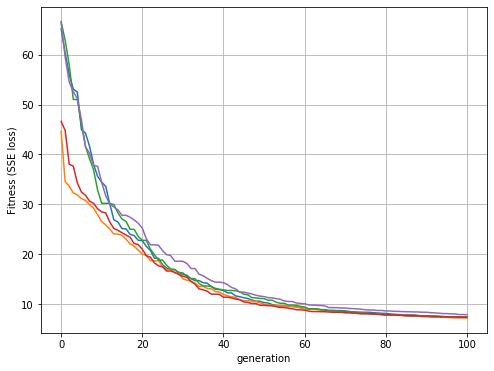

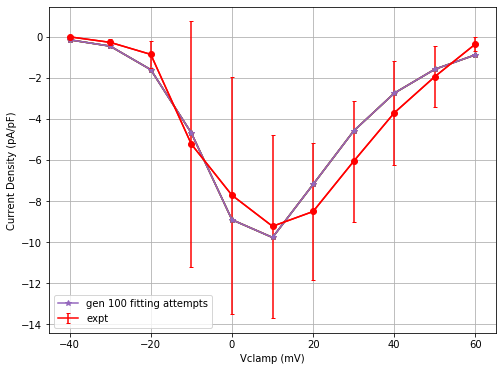

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import ICaL_worker

Vcm = np.arange(-40, 61, 10)
ICaL_act = np.array(
    [0, -0.268792241, -0.856145789, -5.232952504, -7.721339694, -9.236046139, -8.514716429, -6.064719567, -3.704884839,
     -1.937985962, -0.349954573
     ])
ICaL_err = np.array([0, 0.150744503, 0.669532119, 5.982703588, 5.780490069, 4.469592414, 3.35790912, 2.949954933,
                    2.550140897, 1.475404797, 0.348955267])
ICaL_ini_par = np.array([0.2*0.58, 14.1, 6, 30, 5, 0.1])

ICaL_pks_ini = ICaL_worker.ICaL_func(ICaL_ini_par)
time, plt_ICaL, size = ICaL_worker.ICaL_func_time(ICaL_ini_par)

class GA_trial:
    gen_num = 0
    loss = 0
    R_sq_ini = 0
    R_sq_fin = 0
    Parameters = 0
    final_fit_Val = 0
    time = 0
    cur_time_fit = 0
    cur_time_ini = 0
    Vcm = 0
    gen_fit_arr = 0
    I_peaks_fin = 0
    I_peaks_ini = 0
    

GA0 = pickle.load(open('Params/ICaL_Cai_Krta_GA_trial0.p', 'rb'))
GA1 = pickle.load(open('Params/ICaL_Cai_Krta_GA_trial1.p', 'rb'))
GA2 = pickle.load(open('Params/ICaL_Cai_Krta_GA_trial2.p', 'rb'))
GA3 = pickle.load(open('Params/ICaL_Cai_Krta_GA_trial3.p', 'rb'))
GA4 = pickle.load(open('Params/ICaL_Cai_Krta_GA_trial4.p', 'rb'))


print('Parameters_______')
print('0: ', GA0.Parameters)
print('1: ', GA1.Parameters)
print('2: ', GA2.Parameters)
print('3: ', GA3.Parameters)
print('4: ', GA4.Parameters)
# print('5: ', GA5.Parameters)
# print('6: ', GA6.Parameters)
# print('7: ', GA7.Parameters)
# print('8: ', GA8.Parameters)
# print('9: ', GA9.Parameters)
print('\n')

print('R_sq_____')
print('0: ', GA0.R_sq_fin)
print('1: ', GA1.R_sq_fin)
print('2: ', GA2.R_sq_fin)
print('3: ', GA3.R_sq_fin)
print('4: ', GA4.R_sq_fin)
# print('5: ', GA5.R_sq_fin)
# print('6: ', GA6.R_sq_fin)
# print('7: ', GA7.R_sq_fin)
# print('8: ', GA8.R_sq_fin)
# print('9: ', GA9.R_sq_fin)
print('\n')

ICaL_trials_r2 = np.array([GA0.R_sq_fin, GA1.R_sq_fin, GA2.R_sq_fin, GA3.R_sq_fin, GA4.R_sq_fin])
# ICaL_trials_fit = np.array([GA0.final_fit_val, GA1.final_fit_val, GA2.final_fit_val, GA3.final_fit_val, GA4.final_fit_val, 
#                             GA5.final_fit_val, GA6.final_fit_val, GA7.final_fit_val, GA8.final_fit_val, GA9.final_fit_val])

r2_mean = np.mean(ICaL_trials_r2)
r2_stdv = np.std(ICaL_trials_r2)

loss_ini = np.array([GA0.loss[0], GA1.loss[0], GA2.loss[0], GA3.loss[0], GA4.loss[0]])

loss_fin = np.array([GA0.loss[-1], GA1.loss[-1], GA2.loss[-1], GA3.loss[-1], GA4.loss[-1]])

loss_ini_mean = np.mean(loss_ini)
loss_ini_stdv = np.std(loss_ini)

loss_fin_mean = np.mean(loss_fin)
loss_fin_stdv = np.std(loss_fin)

print('R_sq:______')
print('mean R_sq: ', r2_mean)
print('std R_sq: ', r2_stdv)

print('initial losses:______\n ', loss_ini)
print('mean initial loss: ', loss_ini_mean)
print('std initial loss: ', loss_ini_stdv)

print('final losses:______\n ', loss_fin)
print('mean final loss: ', loss_fin_mean)
print('std final loss: ', loss_fin_stdv)

plt.figure(figsize=(8,6))
plt.plot(GA0.gen_num, GA0.loss, label = 0)
plt.plot(GA1.gen_num, GA1.loss, label = 1)
plt.plot(GA2.gen_num, GA2.loss, label = 2)
plt.plot(GA3.gen_num, GA3.loss, label = 3)
plt.plot(GA4.gen_num, GA4.loss, label = 4)
# plt.plot(GA5.gen_num, GA5.loss, label = 5)
# plt.plot(GA6.gen_num, GA6.loss, label = 6)
# plt.plot(GA7.gen_num, GA7.loss, label = 7)
# plt.plot(GA8.gen_num, GA8.loss, label = 8)
# plt.plot(GA9.gen_num, GA9.loss, label = 9)
plt.grid()
# plt.yscale('log')
plt.xlabel('generation')
plt.ylabel('Fitness (SSE loss)')
plt.savefig('multi_gen_loss.png')

ICaL_pks_fit0 = ICaL_worker.ICaL_func(GA0.Parameters)
ICaL_pks_fit1 = ICaL_worker.ICaL_func(GA1.Parameters)
ICaL_pks_fit2 = ICaL_worker.ICaL_func(GA2.Parameters)
ICaL_pks_fit3 = ICaL_worker.ICaL_func(GA3.Parameters)
ICaL_pks_fit4 = ICaL_worker.ICaL_func(GA4.Parameters)

plt.figure(figsize=(8,6))
plt.grid()
plt.plot(GA0.Vcm, ICaL_pks_fit0, '-*')
plt.plot(GA1.Vcm, ICaL_pks_fit1, '-*')
plt.plot(GA2.Vcm, ICaL_pks_fit2, '-*')
plt.plot(GA3.Vcm, ICaL_pks_fit3, '-*')
plt.plot(GA4.Vcm, ICaL_pks_fit4,'-*', label = 'gen 100 fitting attempts')
# plt.plot(GA0.Vcm, ICaL_pks_fit)
# plt.plot(GA5.Vcm, GA5.I_peaks_fin)
# plt.plot(GA6.Vcm, GA6.I_peaks_fin)
# plt.plot(GA7.Vcm, GA7.I_peaks_fin)
# plt.plot(GA8.Vcm, GA8.I_peaks_fin)
# plt.plot(GA9.Vcm, GA9.I_peaks_fin, )
plt.xlabel('Vclamp (mV)')
plt.ylabel('Current Density (pA/pF)')

# plt.plot(Vcm, ICaL_pks_ini, '-*', label='ini_model')
plt.errorbar(Vcm, ICaL_act, yerr=ICaL_err, capsize=2, color='red', label = 'expt')
plt.legend()
plt.plot(Vcm, ICaL_act, 'r-o')
plt.show()
#plt.savefig('multi_gen_IV.png')     

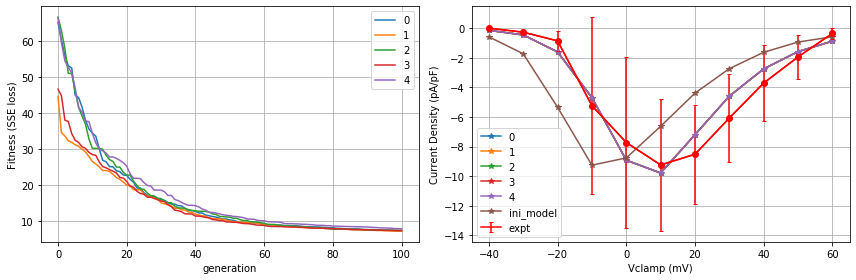

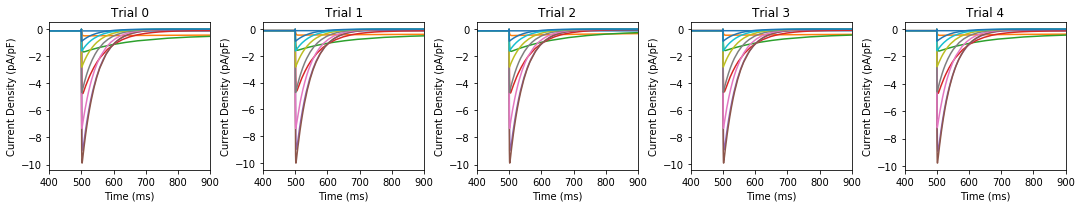

In [6]:
# ICaL_pks_ini = ICaL_worker.ICaL_func(ICaL_ini_par)
plt.figure(figsize = (12,4))
plt.subplot(122)
plt.grid()
# plt.title('A')
plt.plot(GA0.Vcm, ICaL_pks_fit0, '-*', label = '0')
plt.plot(GA1.Vcm, ICaL_pks_fit1, '-*', label = '1')
plt.plot(GA2.Vcm, ICaL_pks_fit2, '-*', label = '2')
plt.plot(GA3.Vcm, ICaL_pks_fit3, '-*', label = '3')
plt.plot(GA4.Vcm, ICaL_pks_fit4, '-*', label = '4')
plt.xlabel('Vclamp (mV)')
plt.ylabel('Current Density (pA/pF)')
ICaL_pks_ini = ICaL_worker.ICaL_func(ICaL_ini_par)
plt.plot(Vcm, ICaL_pks_ini, '-*', label='ini_model')
plt.errorbar(Vcm, ICaL_act, yerr=ICaL_err, capsize=2, color='red', label = 'expt')
plt.legend()
plt.plot(Vcm, ICaL_act, 'r-o', label = 'expt')

plt.subplot(121)
plt.grid()
# plt.title('B')
plt.plot(GA0.gen_num, GA0.loss, label = '0')
plt.plot(GA1.gen_num, GA1.loss, label = '1')
plt.plot(GA2.gen_num, GA2.loss, label = '2')
plt.plot(GA3.gen_num, GA3.loss, label = '3')
plt.plot(GA4.gen_num, GA4.loss, label = '4')
# plt.plot(GA5.gen_num, GA5.loss, label = 'Trial 5')
# plt.plot(GA6.gen_num, GA6.loss, label = 'Trial 6')
# plt.plot(GA7.gen_num, GA7.loss, label = 'Trial 7')
# plt.plot(GA8.gen_num, GA8.loss, label = 'Trial 8')
# plt.plot(GA9.gen_num, GA9.loss, label = 'Trial 9')
# plt.yscale('log')
plt.xlabel('generation')
plt.ylabel('Fitness (SSE loss)')
plt.legend()
plt.tight_layout()
plt.savefig('ICaL_fits_n_loss.png')
plt.show()

plt.figure(figsize=(15,3))
# GA1.Parameters[-1] = GA0.Parameters[-1]
plt.subplot2grid((1,5), (0,0))
time, GA0_time_course, s0 = ICaL_worker.ICaL_func_time(GA0.Parameters)
for j in np.arange(len(Vcm)):
    plt.plot(time[j, : s0[j]], GA0_time_course[j, : s0[j]])
plt.xlabel('Time (ms)')
plt.ylabel('Current Density (pA/pF)')
plt.title('Trial 0')
plt.xlim(400,900)
plt.subplot2grid((1,5), (0,1))
time, GA1_time_course, s1 = ICaL_worker.ICaL_func_time(GA1.Parameters)
for j in np.arange(len(Vcm)):
    plt.plot(time[j, : s1[j]], GA1_time_course[j, : s1[j]])
plt.xlabel('Time (ms)')
plt.ylabel('Current Density (pA/pF)')
plt.title('Trial 1')
plt.xlim(400,900)
plt.subplot2grid((1,5), (0,2))
time, GA2_time_course, s2 = ICaL_worker.ICaL_func_time(GA2.Parameters)
for j in np.arange(len(Vcm)):
    plt.plot(time[j, : s2[j]], GA2_time_course[j, : s2[j]])
plt.xlabel('Time (ms)')
plt.ylabel('Current Density (pA/pF)')
plt.title('Trial 2')
plt.xlim(400,900)
plt.subplot2grid((1,5), (0,3))
time, GA3_time_course, s3 = ICaL_worker.ICaL_func_time(GA3.Parameters)
for j in np.arange(len(Vcm)):
    plt.plot(time[j, : s3[j]], GA3_time_course[j, : s3[j]])
plt.xlabel('Time (ms)')
plt.ylabel('Current Density (pA/pF)')
plt.title('Trial 3')
plt.xlim(400,900)
plt.subplot2grid((1,5), (0,4))
time, GA4_time_course, s4 = ICaL_worker.ICaL_func_time(GA4.Parameters)
for j in np.arange(len(Vcm)):
    plt.plot(time[j, : s4[j]], GA4_time_course[j, : s4[j]])
plt.xlabel('Time (ms)')
plt.ylabel('Current Density (pA/pF)')
plt.title('Trial 4')
plt.xlim(400,900)

plt.tight_layout()
plt.savefig('ICaL_time_course_fits.png')
plt.show()

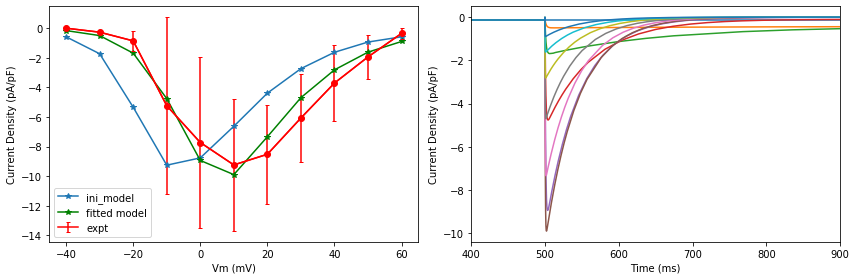

In [9]:
time, GA0_time_course, s0 = ICaL_worker.ICaL_func_time(GA0.Parameters)
plt.figure(figsize = (12,4))
plt.subplot(121)
ICaL_ini_par = np.array([0.2*0.58, 14.1, 6, 30, 5, 0.1])
ICaL_pks_ini = ICaL_worker.ICaL_func(ICaL_ini_par)
plt.plot(Vcm, ICaL_pks_ini, '-*', label='ini_model')
ICaL_pks_f = ICaL_worker.ICaL_func(GA0.Parameters)
plt.plot(Vcm, ICaL_pks_f, 'g-*', label = 'fitted model')
plt.errorbar(Vcm, ICaL_act, yerr=ICaL_err, capsize=2, color='red', label = 'expt')
plt.legend()
plt.plot(Vcm, ICaL_act, 'r-o')
plt.xlabel('Vm (mV)')
plt.ylabel('Current Density (pA/pF)')

plt.subplot(122)
time, GA0_time_course, s0 = ICaL_worker.ICaL_func_time(GA0.Parameters)
for j in np.arange(len(Vcm)):
    plt.plot(time[j, : s0[j]], GA0_time_course[j, : s0[j]])
plt.xlim(400,900)
plt.xlabel('Time (ms)')
plt.ylabel('Current Density (pA/pF)')
plt.tight_layout()
plt.savefig('ICaL_IV_n_time_fit.png')
plt.show()